In [3]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import string
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import tensorflow as tf
import tensorflow_hub as hub
import copy
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the data
data = []
with gzip.open('video.json.gz',"rb") as f:
    for l in f:
        data.append(json.loads(l.strip()))
print(f"Length of data: {len(data)}")
print(f"First row of the list: {data[0]}")

Length of data: 2565349
First row of the list: {'overall': 1.0, 'verified': True, 'reviewTime': '06 9, 2014', 'reviewerID': 'A21ROB4YDOZA5P', 'asin': '0439381673', 'reviewerName': 'Mary M. Clark', 'reviewText': 'I used to play this game years ago and loved it. I found this did not work on my computer even though it said it would work with Windows 7.', 'summary': 'Did not like this', 'unixReviewTime': 1402272000}


In [5]:
# Convert the list into pandas dataframe
df = pd.DataFrame(data)
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"06 9, 2014",A21ROB4YDOZA5P,0439381673,Mary M. Clark,I used to play this game years ago and loved i...,Did not like this,1402272000,NaN,NaN,NaN
1,3.0,True,"05 10, 2014",A3TNZ2Q5E7HTHD,0439381673,Sarabatya,The game itself worked great but the story lin...,Almost Perfect,1399680000,NaN,NaN,NaN
2,4.0,True,"02 7, 2014",A1OKRM3QFEATQO,0439381673,Amazon Customer,I had to learn the hard way after ordering thi...,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,1391731200,15,NaN,NaN
3,1.0,True,"02 7, 2014",A2XO1JFCNEYV3T,0439381673,ColoradoPartyof5,The product description should state this clea...,does not work on Mac OSX,1391731200,11,NaN,NaN
4,4.0,True,"01 16, 2014",A19WLPIRHD15TH,0439381673,Karen Robinson,I would recommend this learning game for anyon...,Roughing it,1389830400,NaN,NaN,NaN


In [6]:
# Convert reviewTime column to pandas datetime format
df.reviewTime = pd.to_datetime(df.reviewTime)

In [7]:
df.groupby('verified').overall.mean()

verified
False    3.766244
True     4.103124
Name: overall, dtype: float64

We find that verified review tends to have higher rating than average. Now, we make a plot for the distribution of ratings, verified and unverified.

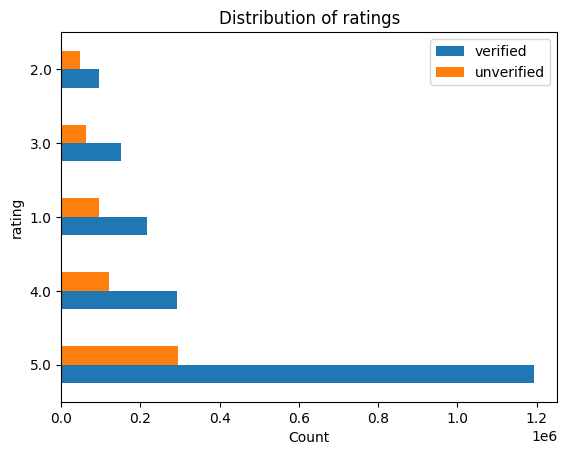

In [8]:
(pd.concat([df.loc[df.verified].overall.value_counts().to_frame().rename({'overall': 'verified'}, axis=1), 
    df.loc[~df.verified].overall.value_counts().to_frame().rename({'overall': 'unverified'}, axis=1)], axis=1)
    .plot(kind='barh', title = 'Distribution of ratings', xlabel='Count', ylabel='rating'));

In [9]:
df.reviewTime.apply(lambda x: x.year)

0          2014
1          2014
2          2014
3          2014
4          2014
           ... 
2565344    2018
2565345    2018
2565346    2018
2565347    2018
2565348    2018
Name: reviewTime, Length: 2565349, dtype: int64

From the plot, we can find that verified and unverified reviews have similar amounts of 1 and 2 star ratings. Verified reviews tend to have slightly more 3 and 4 star ratings and have significantly more 5 star rating than unverified reviews

Let's also investigate the relationship between review time and rating.

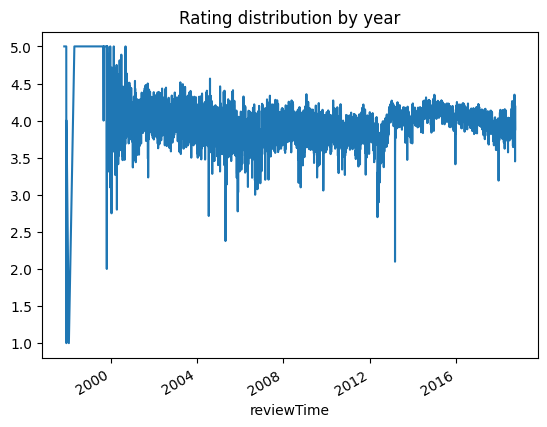

In [10]:
df.groupby('reviewTime').overall.mean().plot(title = 'Rating distribution by year');

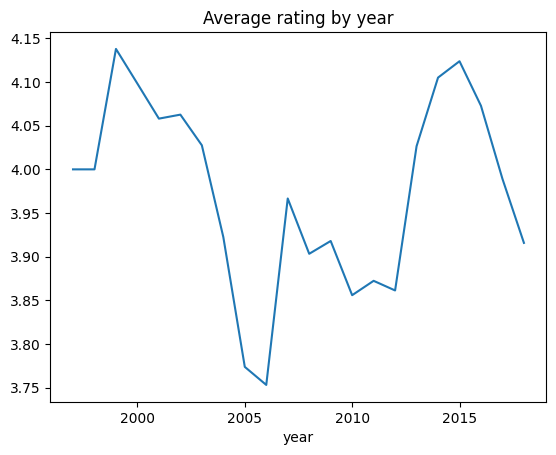

In [29]:
df.assign(year = df.reviewTime.apply(lambda x: x.year)).groupby('year').overall.mean().plot(title = 'Average rating by year');

According to the plot, there does not exist a seemingly linear correlation between review time and average rating. However, annual average rating does fluctuate a lot. The average rating started to decrease overall since 1999, which is the earliest time in the dataset, reached the bottom in about 2006, and started to rised until 2015.

# Data Preprocessing

In [12]:
df = shuffle(df)
train = df.iloc[:int(df.shape[0]*4/5)]
test = df.iloc[int(df.shape[0]*4/5):]
train_df = train.sample(100000)
test_df = test.sample(20000)

def feature(t):
    t = str(t)
    t = t.lower().strip()
    t = [c for c in t if not (c in punct)]
    t = ''.join(t) 
    return t

punct = string.punctuation
ratings_train = train_df["overall"]
reviews_train = train_df["reviewText"].apply(feature)
ratings_test = test_df["overall"]
reviews_test = test_df["reviewText"].apply(feature)

In [13]:
def MSE(pred, true):
    return sum(np.square(pred-true))/len(pred)

def RMSE(pred, true):
    return np.sqrt(sum(np.square(pred-true))/len(pred))

We strip all the stopwords and vectorize all review text here. 

# Baselines

Instead of treating ratings as a numerical linear prediction, in this section we will treat ratings as categorical variables on which we can make classification prediction. While ratings of "5" could be interpreted as "highly recommend", ratings of "1" could be interpreted as "not recommend as at". 

We firstly randomly shuffle the data and extract 100000 samples from the first 4/5 of shuffled data as training data while extract 20000 samples of the last 1/5 of shuffled data as test data. We did this as the training time for full data could be extremely long, and as we actually "randomly filter" (shuffled() and sample()) twice, we can make sure the distribution of our sampled data is the same as original full data.

## Baseline Model 1: Plain Regression With Stop Words Removed Rating Classification prediction from reviewText

In [14]:
vectorizer= CountVectorizer(analyzer = "word", stop_words = "english")
plain_x_train = vectorizer.fit_transform(reviews_train)
plain_x_test = vectorizer.transform(reviews_test)

In [15]:
clf_log = linear_model.LogisticRegression(class_weight = "balanced")
clf_log.fit(plain_x_train,ratings_train)
plain_test_log = clf_log.predict(plain_x_test)

In [16]:
np.mean(plain_test_log== ratings_test.values)

0.5949

In [17]:
print("RMSE for ratings prediction using Plain Regression is {}".format(RMSE(plain_test_log, ratings_test.values)))
print("MSE for ratings prediction using Plain Regression is {}".format(MSE(plain_test_log, ratings_test.values)))
print("Accuracy of rating predictions using Plain Regression is {}".format(np.mean(plain_test_log==ratings_test.values)))

RMSE for ratings prediction using Plain Regression is 1.1386175828609006
MSE for ratings prediction using Plain Regression is 1.29645
Accuracy of rating predictions using Plain Regression is 0.5949


## Baseline Model 2: SVM With Stop Words Removed Rating Classification prediction from reviewText

In [18]:
svm_log = LinearSVC(class_weight = "balanced")
svm_log.fit(plain_x_train,ratings_train)

LinearSVC(class_weight='balanced')

In [19]:
svm_test_log = svm_log.predict(plain_x_test)

In [20]:
print("RMSE for ratings prediction using Plain Regression is {}".format(RMSE(svm_test_log, ratings_test.values)))
print("MSE for ratings prediction using Plain Regression is {}".format(MSE(svm_test_log, ratings_test.values)))
print("Accuracy of rating predictions using Plain Regression is {}".format(np.mean(svm_test_log==ratings_test.values)))

RMSE for ratings prediction using Plain Regression is 1.1613569649336934
MSE for ratings prediction using Plain Regression is 1.34875
Accuracy of rating predictions using Plain Regression is 0.6275


## Baseline Model 3: TFIDF-based Rating Classification prediction from reviewText

In [21]:
vectorizer= TfidfVectorizer(analyzer = "word", stop_words = "english")
tf_x_train = vectorizer.fit_transform(reviews_train)
tf_x_test = vectorizer.transform(reviews_test)

In [22]:
clf_log = linear_model.LogisticRegression(class_weight = "balanced")
clf_log.fit(tf_x_train,ratings_train)
pred_test_log = clf_log.predict(tf_x_test)

In [23]:
np.mean(pred_test_log== ratings_test.values)

0.58085

In [24]:
print("RMSE for ratings prediction using TFIDF is {}".format(RMSE(pred_test_log, ratings_test.values)))
print("MSE for ratings prediction using TFIDF is {}".format(MSE(pred_test_log, ratings_test.values)))
print("Accuracy of rating predictions using TFIDF is {}".format(np.mean(pred_test_log==ratings_test.values)))

RMSE for ratings prediction using TFIDF is 1.1606032913963324
MSE for ratings prediction using TFIDF is 1.347
Accuracy of rating predictions using TFIDF is 0.58085


## Baseline Model 4: TFIDF-based Rating Classification prediction from reviewText with SVM

In [25]:
svm_tfidf_log = LinearSVC(class_weight = "balanced")
svm_tfidf_log.fit(tf_x_train,ratings_train)

LinearSVC(class_weight='balanced')

In [26]:
svm_tfidf_test_log = svm_tfidf_log.predict(tf_x_test)

In [27]:
print("RMSE for ratings prediction using TFIDF is {}".format(RMSE(svm_tfidf_test_log, ratings_test.values)))
print("MSE for ratings prediction using TFIDF is {}".format(MSE(svm_tfidf_test_log, ratings_test.values)))
print("Accuracy of rating predictions using TFIDF is {}".format(np.mean(svm_tfidf_test_log==ratings_test.values)))

RMSE for ratings prediction using TFIDF is 1.1248110952511092
MSE for ratings prediction using TFIDF is 1.2652
Accuracy of rating predictions using TFIDF is 0.63415


## Baseline Model 5: Linear Regression with word2vec

In [14]:
vectorizer= CountVectorizer(analyzer = "word", stop_words = "english")
plain_x_train = vectorizer.fit_transform(reviews_train)
plain_x_test = vectorizer.transform(reviews_test)

In [15]:
clf_log = linear_model.LogisticRegression(class_weight = "balanced")
clf_log.fit(plain_x_train,ratings_train)
plain_test_log = clf_log.predict(plain_x_test)

In [16]:
np.mean(plain_test_log== ratings_test.values)

0.5949

In [17]:
print("RMSE for ratings prediction using Plain Regression is {}".format(RMSE(plain_test_log, ratings_test.values)))
print("MSE for ratings prediction using Plain Regression is {}".format(MSE(plain_test_log, ratings_test.values)))
print("Accuracy of rating predictions using Plain Regression is {}".format(np.mean(plain_test_log==ratings_test.values)))

RMSE for ratings prediction using Plain Regression is 1.1386175828609006
MSE for ratings prediction using Plain Regression is 1.29645
Accuracy of rating predictions using Plain Regression is 0.5949


## Baseline Model 6: SVM with word2vec

In [69]:
cvrtY = convert_back_rating(trainY)
cvrtY.shape

(20000,)

In [71]:
svm_tfidf_log = LinearSVC(class_weight = "balanced")
svm_tfidf_log.fit(trainX.reshape(20000,-1), cvrtY)

LinearSVC(class_weight='balanced')

In [73]:
svm_tfidf_test_log = svm_tfidf_log.predict(testX.reshape(10000,-1))

In [74]:
print("RMSE for ratings prediction using Plain Regression is {}".format(RMSE(svm_tfidf_test_log, actual)))
print("MSE for ratings prediction using Plain Regression is {}".format(MSE(svm_tfidf_test_log, actual)))
print("Accuracy of rating predictions using Plain Regression is {}".format(np.mean(svm_tfidf_test_log==actual)))

RMSE for ratings prediction using Plain Regression is 1.5979987484350542
MSE for ratings prediction using Plain Regression is 2.5536
Accuracy of rating predictions using Plain Regression is 0.5125


## Model 2: LSTM with word2vec for rating prediction

Since we only prediction rating through reviews text, we would use LSTM based on word2vec encoding for rating prediction. Instead of training a encoder by ourself, we would use the word2vec model from tensoflow hub website, the links is below.

In [75]:
word2vec= hub.load("https://tfhub.dev/google/Wiki-words-250/2")

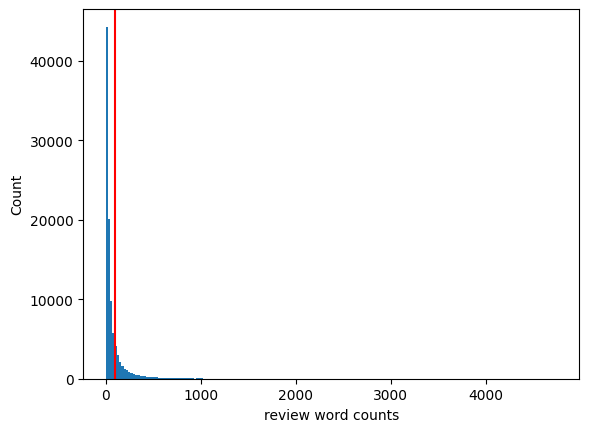

In [94]:
train_df = train.sample(100000)
plt.hist(train_df["reviewText"].apply(feature).apply(lambda x:len(x.split(" "))), bins = 200)
plt.xlabel("review word counts")
plt.ylabel("Count")
plt.axvline(100,color="red")
plt.show()

As we can see in the above histogram, most reviews words count are within 200, so we would using 200 as the length of our encoded vector. 

In [86]:
def encode(reviews):
    result = []
    for txt in reviews:
        encoded = word2vec(str(txt).split(" ")[:100])
        pad_len = 100 - encoded.shape[0]
        unit = np.zeros((1, 250))
        for i in range(pad_len):
            encoded = np.concatenate((unit, encoded), axis=0)
        result.append(encoded)
    return result

def rating_encode(rating):
    arr = [0,0,0,0,0]
    arr[int(rating)-1] = 1
    return arr

def getXY(df):
    reviews = df['reviewText'].tolist()
    encoding = encode(reviews)
    X = np.array(encoding)
    ratings = df["overall"].astype(int).tolist()
    encoded_ratings = [rating_encode(i) for i in ratings]
    Y = np.array(encoded_ratings)
    return X,Y

In [87]:
trainX,trainY = getXY(train_df)

In [88]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history=model.fit(trainX, trainY,epochs=50)

Epoch 1/50
3125/3125 [==============================] - 39s 12ms/step - loss: 1.1028 - accuracy: 0.5925
Epoch 2/50
3125/3125 [==============================] - 37s 12ms/step - loss: 1.0171 - accuracy: 0.6172
Epoch 3/50
3125/3125 [==============================] - 37s 12ms/step - loss: 0.9848 - accuracy: 0.6280
Epoch 4/50
3125/3125 [==============================] - 36s 12ms/step - loss: 0.9610 - accuracy: 0.6356
Epoch 5/50
3125/3125 [==============================] - 36s 12ms/step - loss: 0.9432 - accuracy: 0.6429
Epoch 6/50
3125/3125 [==============================] - 36s 12ms/step - loss: 0.9280 - accuracy: 0.6487
Epoch 7/50
3125/3125 [==============================] - 36s 12ms/step - loss: 0.9156 - accuracy: 0.6536
Epoch 8/50
3125/3125 [==============================] - 36s 12ms/step - loss: 0.9065 - accuracy: 0.6559
Epoch 9/50
3125/3125 [==============================] - 37s 12ms/step - loss: 0.8978 - accuracy: 0.6592
Epoch 10/50
3125/3125 [==============================] - 36s 11m

In [89]:
testX,testY = getXY(test.sample(10000))
acc = model.predict(testX)

313/313 [==============================] - 3s 7ms/step


In [90]:
def convert_back_rating(ratings):
    return np.array([np.argmax(i)+1 for i in ratings.tolist()])

In [91]:
pred = convert_back_rating(acc)
actual = convert_back_rating(testY)

In [92]:
print("RMSE for ratings prediction using LSTM is {}".format(RMSE(pred,actual)))
print("MSE for ratings prediction using LSTM is {}".format(MSE(pred,actual)))
print("Accuracy of rating predictions using LSTM is {}".format(np.mean(pred==actual)))

RMSE for ratings prediction using LSTM is 1.1396051947933548
MSE for ratings prediction using LSTM is 1.2987
Accuracy of rating predictions using LSTM is 0.6727


As we can see, the MSE and RMSE is even no better than the baseline model with basic TFIDF with logistic regression. However, the classification accuracy is substantially better, this is because we train the classifier with categorical_crossentropy, which means that we purely treat the ratings with no numerical meaning. We just care about whether the prediction ratings is the same number as actual ratings. 